# Visualizing On- and Off-Target Morphological Signatures

This notebook evaluates whether our morphological signatures effectively capture phenotypic differences. We apply PCA and UMAP to reduce the feature space to two dimensions and visualize the distribution of DMSO (negative control) and TGFRi (positive control) treated cells at the single-cell level.

In [1]:
# Load required libraries
suppressPackageStartupMessages({
    library(tidyverse)
    library(arrow)
    library(jsonlite)
    library(ggplot2)
    library(patchwork)
    library(scales)
    library(umap)
    library(magick)
    library(dplyr)
    library(RColorBrewer)
})


Setting global configurations for plotting

In [2]:
# Set random seed for reproducibility
set.seed(0)

# ggplot configuration
theme_set(
    theme_minimal(base_size = 12, base_family = "sans") +
    theme(
        # Axis styling
        axis.line = element_line(color = "black", linewidth = 0.5),
        axis.ticks = element_line(color = "black", linewidth = 0.5),
        axis.text = element_text(color = "black", size = 10),
        axis.title = element_text(face = "bold", size = 11),
        
        # Panel styling
        panel.grid.major = element_line(color = "grey90", linewidth = 0.25),
        panel.grid.minor = element_blank(),
        panel.background = element_rect(fill = "white", color = NA),
        panel.border = element_blank(),
        
        # Plot styling
        plot.title = element_text(face = "bold", size = 13, hjust = 0.5),
        plot.subtitle = element_text(size = 10, hjust = 0.5, color = "grey40"),
        plot.background = element_rect(fill = "white", color = NA),
        
        # Legend styling
        legend.position = "right",
        legend.title = element_text(face = "bold", size = 10),
        legend.text = element_text(size = 9),
        legend.background = element_rect(fill = "white", color = "grey80", linewidth = 0.3),
        legend.key = element_blank(),
        
        # Strip styling for facets
        strip.text = element_text(face = "bold", size = 11),
        strip.background = element_rect(fill = "grey95", color = "grey80")
    )
)

# color palette - using Dark2 from RColorBrewer
# Get the number of unique cell_treatment combinations
color_palette <- brewer.pal(8, "Dark2")

Setting up input and output paths

In [3]:
# Define directory paths
module_results_dir <- file.path("..", "results")
figures_dir <- file.path(".", "figures")

# Input paths for pre-computed PCA and UMAP results
pca_dir <- file.path(module_results_dir, "pca")
umap_dir <- file.path(module_results_dir, "umap")

# PCA file paths
pca_on_path <- file.path(pca_dir, "cfret_pilot_on_morph_pca.parquet")
pca_off_path <- file.path(pca_dir, "cfret_pilot_off_morph_pca.parquet")
pca_on_var_exp_path <- file.path(pca_dir, "cfret_pilot_on_morph_pca_var_explained.parquet")
pca_off_var_exp_path <- file.path(pca_dir, "cfret_pilot_off_morph_pca_var_explained.parquet")

# check if these files exist
if (!file.exists(pca_on_path)) stop("PCA on-target file not found")
if (!file.exists(pca_off_path)) stop("PCA off-target file not found")
if (!file.exists(pca_on_var_exp_path)) stop("PCA on-target explained variance file not found")
if (!file.exists(pca_off_var_exp_path)) stop("PCA off-target explained variance file not found")

# UMAP file paths
umap_global_path <- file.path(umap_dir, "cfret_pilot_all_morph_umap.parquet")
umap_on_path <- file.path(umap_dir, "cfret_pilot_on_morph_umap.parquet")
umap_off_path <- file.path(umap_dir, "cfret_pilot_off_morph_umap.parquet")

# Verify files exist
if (!file.exists(pca_on_path)) stop("PCA on-target file not found")
if (!file.exists(pca_off_path)) stop("PCA off-target file not found")
if (!file.exists(umap_on_path)) stop("UMAP on-target file not found")
if (!file.exists(umap_off_path)) stop("UMAP off-target file not found")

In [4]:
# Create figures directory
dir.create(figures_dir, showWarnings = FALSE, recursive = TRUE)

cat("Figures directory created at:", figures_dir, "\n")

Figures directory created at: ./figures 


Load PCA embeddings

In [5]:
# Load PCA results
pca_on_df <- read_parquet(pca_on_path)
pca_off_df <- read_parquet(pca_off_path)
pca_on_var_exp_df <- read_parquet(pca_on_var_exp_path)
pca_off_var_exp_df <- read_parquet(pca_off_var_exp_path)

# creating a new column that contains the cell_type and treatment info concatenated 
# with an underscore
pca_on_df <- pca_on_df %>%
    mutate(Metadata_cell_treatment = paste(Metadata_cell_type, Metadata_treatment, sep = "_"))
pca_off_df <- pca_off_df %>%
    mutate(Metadata_cell_treatment = paste(Metadata_cell_type, Metadata_treatment, sep = "_"))

# Display structure
cat("PCA ON shape:", nrow(pca_on_df), "×", ncol(pca_on_df), "\n")
cat("PCA OFF shape:", nrow(pca_off_df), "×", ncol(pca_off_df), "\n")

# Display cell counts by treatment
cell_counts_on <- pca_on_df %>%
    group_by(Metadata_treatment) %>%
    summarise(n_cells = n(), .groups = 'drop')

cat("\nCell counts by treatment:\n")
print(cell_counts_on)

# Verify required columns exist
required_cols <- c("PC1", "PC2", "Metadata_treatment")
if (!all(required_cols %in% names(pca_on_df))) {
    stop("Required columns missing in PCA data")
}

PCA ON shape: 15793 × 23 
PCA OFF shape: 15793 × 23 

Cell counts by treatment:
# A tibble: 2 × 2
  Metadata_treatment n_cells
  <chr>                <int>
1 DMSO                 10519
2 TGFRi                 5274


## Plotting PCA embeddings

Setting plot configurations

In [6]:
# Plot dimensions (in inches)
plot_width_combined <- 12
plot_height_combined <- 5.5
plot_width_faceted <- 10
plot_height_faceted <- 9

# Point styling
point_alpha <- 0.3
point_size <- 1.5
point_shape <- 16  # filled circle

# Faceted plot styling
facet_point_alpha <- 0.4
facet_point_size <- 1.2

# Legend styling
legend_alpha <- 1
legend_size <- 3

# Resolution for rendering
render_dpi <- 300

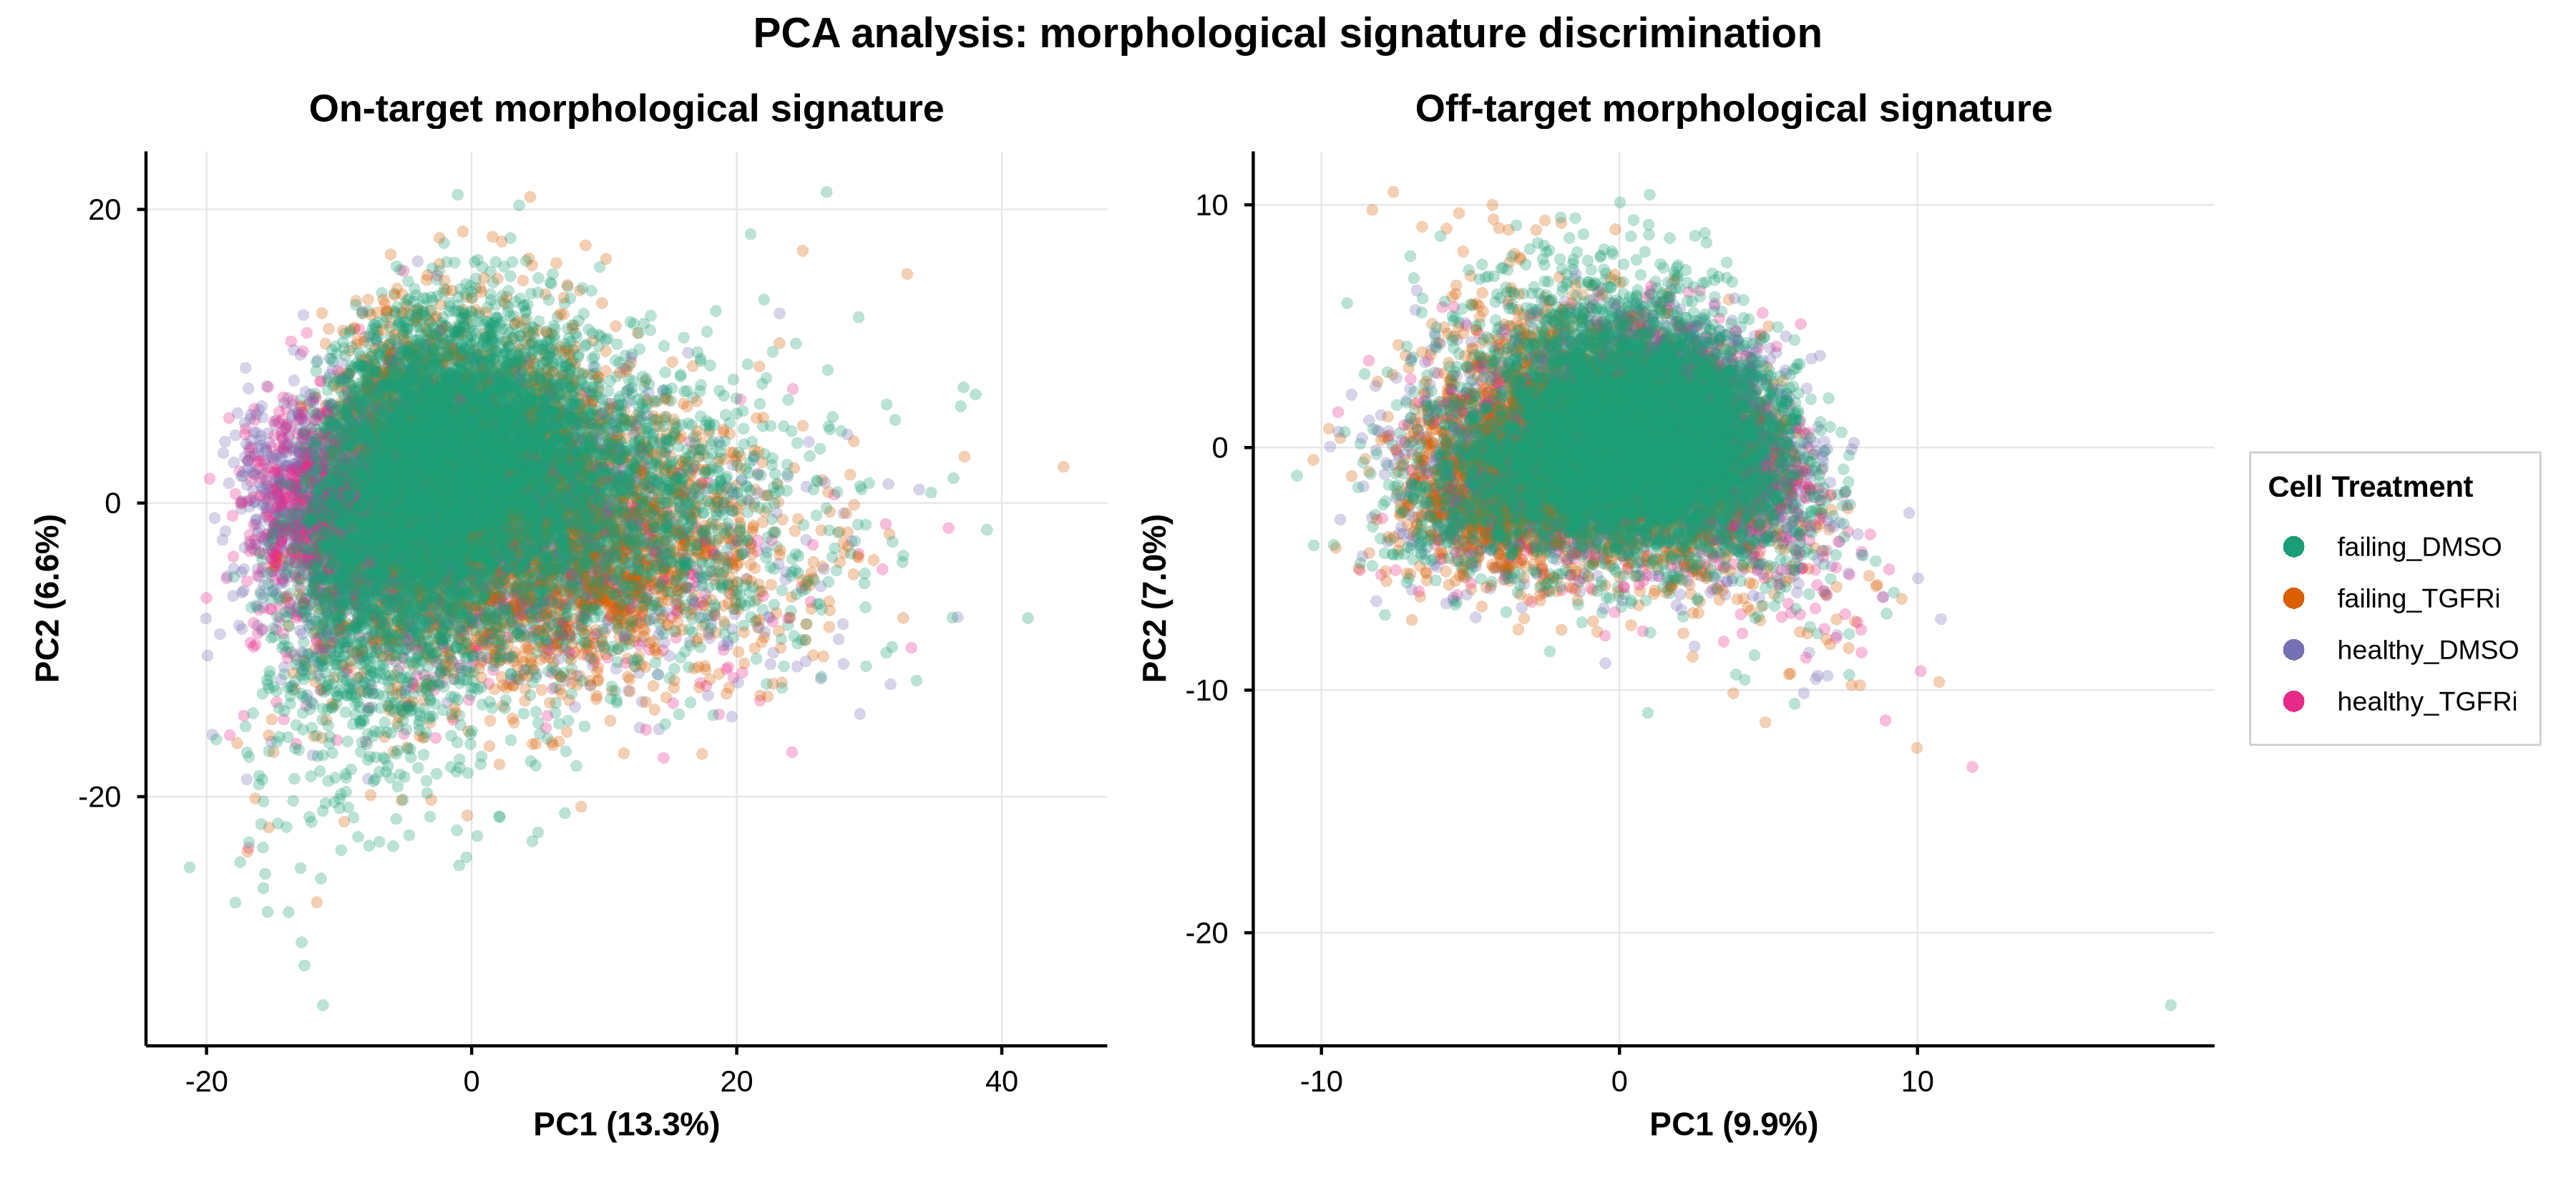

In [7]:
# Extract variance explained values for axis labels
pc1_var_on <- pca_on_var_exp_df %>% filter(PC == "PC1") %>% pull(Metadata_explained_variance_ratio) * 100
pc2_var_on <- pca_on_var_exp_df %>% filter(PC == "PC2") %>% pull(Metadata_explained_variance_ratio) * 100
pc1_var_off <- pca_off_var_exp_df %>% filter(PC == "PC1") %>% pull(Metadata_explained_variance_ratio) * 100
pc2_var_off <- pca_off_var_exp_df %>% filter(PC == "PC2") %>% pull(Metadata_explained_variance_ratio) * 100

# Create on-target PCA plot
plot_pca_on <- ggplot(pca_on_df, aes(x = PC1, y = PC2, color = Metadata_cell_treatment)) +
    geom_point(alpha = point_alpha, size = point_size, shape = point_shape) +
    scale_color_manual(values = color_palette, name = "Cell Treatment") +
    labs(
        title = "On-target morphological signature",
        x = sprintf("PC1 (%.1f%%)", pc1_var_on),
        y = sprintf("PC2 (%.1f%%)", pc2_var_on)
    ) +
    guides(color = guide_legend(override.aes = list(alpha = legend_alpha, size = legend_size)))

# Create off-target PCA plot
plot_pca_off <- ggplot(pca_off_df, aes(x = PC1, y = PC2, color = Metadata_cell_treatment)) +
    geom_point(alpha = point_alpha, size = point_size, shape = point_shape) +
    scale_color_manual(values = color_palette, name = "Cell Treatment") +
    labs(
        title = "Off-target morphological signature",
        x = sprintf("PC1 (%.1f%%)", pc1_var_off),
        y = sprintf("PC2 (%.1f%%)", pc2_var_off)
    ) +
    guides(color = guide_legend(override.aes = list(alpha = legend_alpha, size = legend_size)))

# Combine plots using patchwork
pca_combined <- plot_pca_on + plot_pca_off +
    plot_layout(guides = "collect") +
    plot_annotation(
        title = "PCA analysis: morphological signature discrimination",
        theme = theme(plot.title = element_text(face = "bold", size = 14, hjust = 0.5))
    )

# Display plot
options(repr.plot.width = plot_width_combined, repr.plot.height = plot_height_combined, repr.plot.res = render_dpi)
print(pca_combined)

In [8]:
# Save PCA overlay comparison
ggsave(
    filename = file.path(figures_dir, "pca_on_off_comparison.png"),
    plot = pca_combined,
    width = plot_width_combined,
    height = plot_height_combined,
    dpi = render_dpi,
    bg = "white"
)

cat("Saved PCA overlay plots to:", figures_dir, "\n")

Saved PCA overlay plots to: ./figures 


### PCA visualization: faceted by treatment

Individual treatment groups displayed separately to examine within-group distributions.

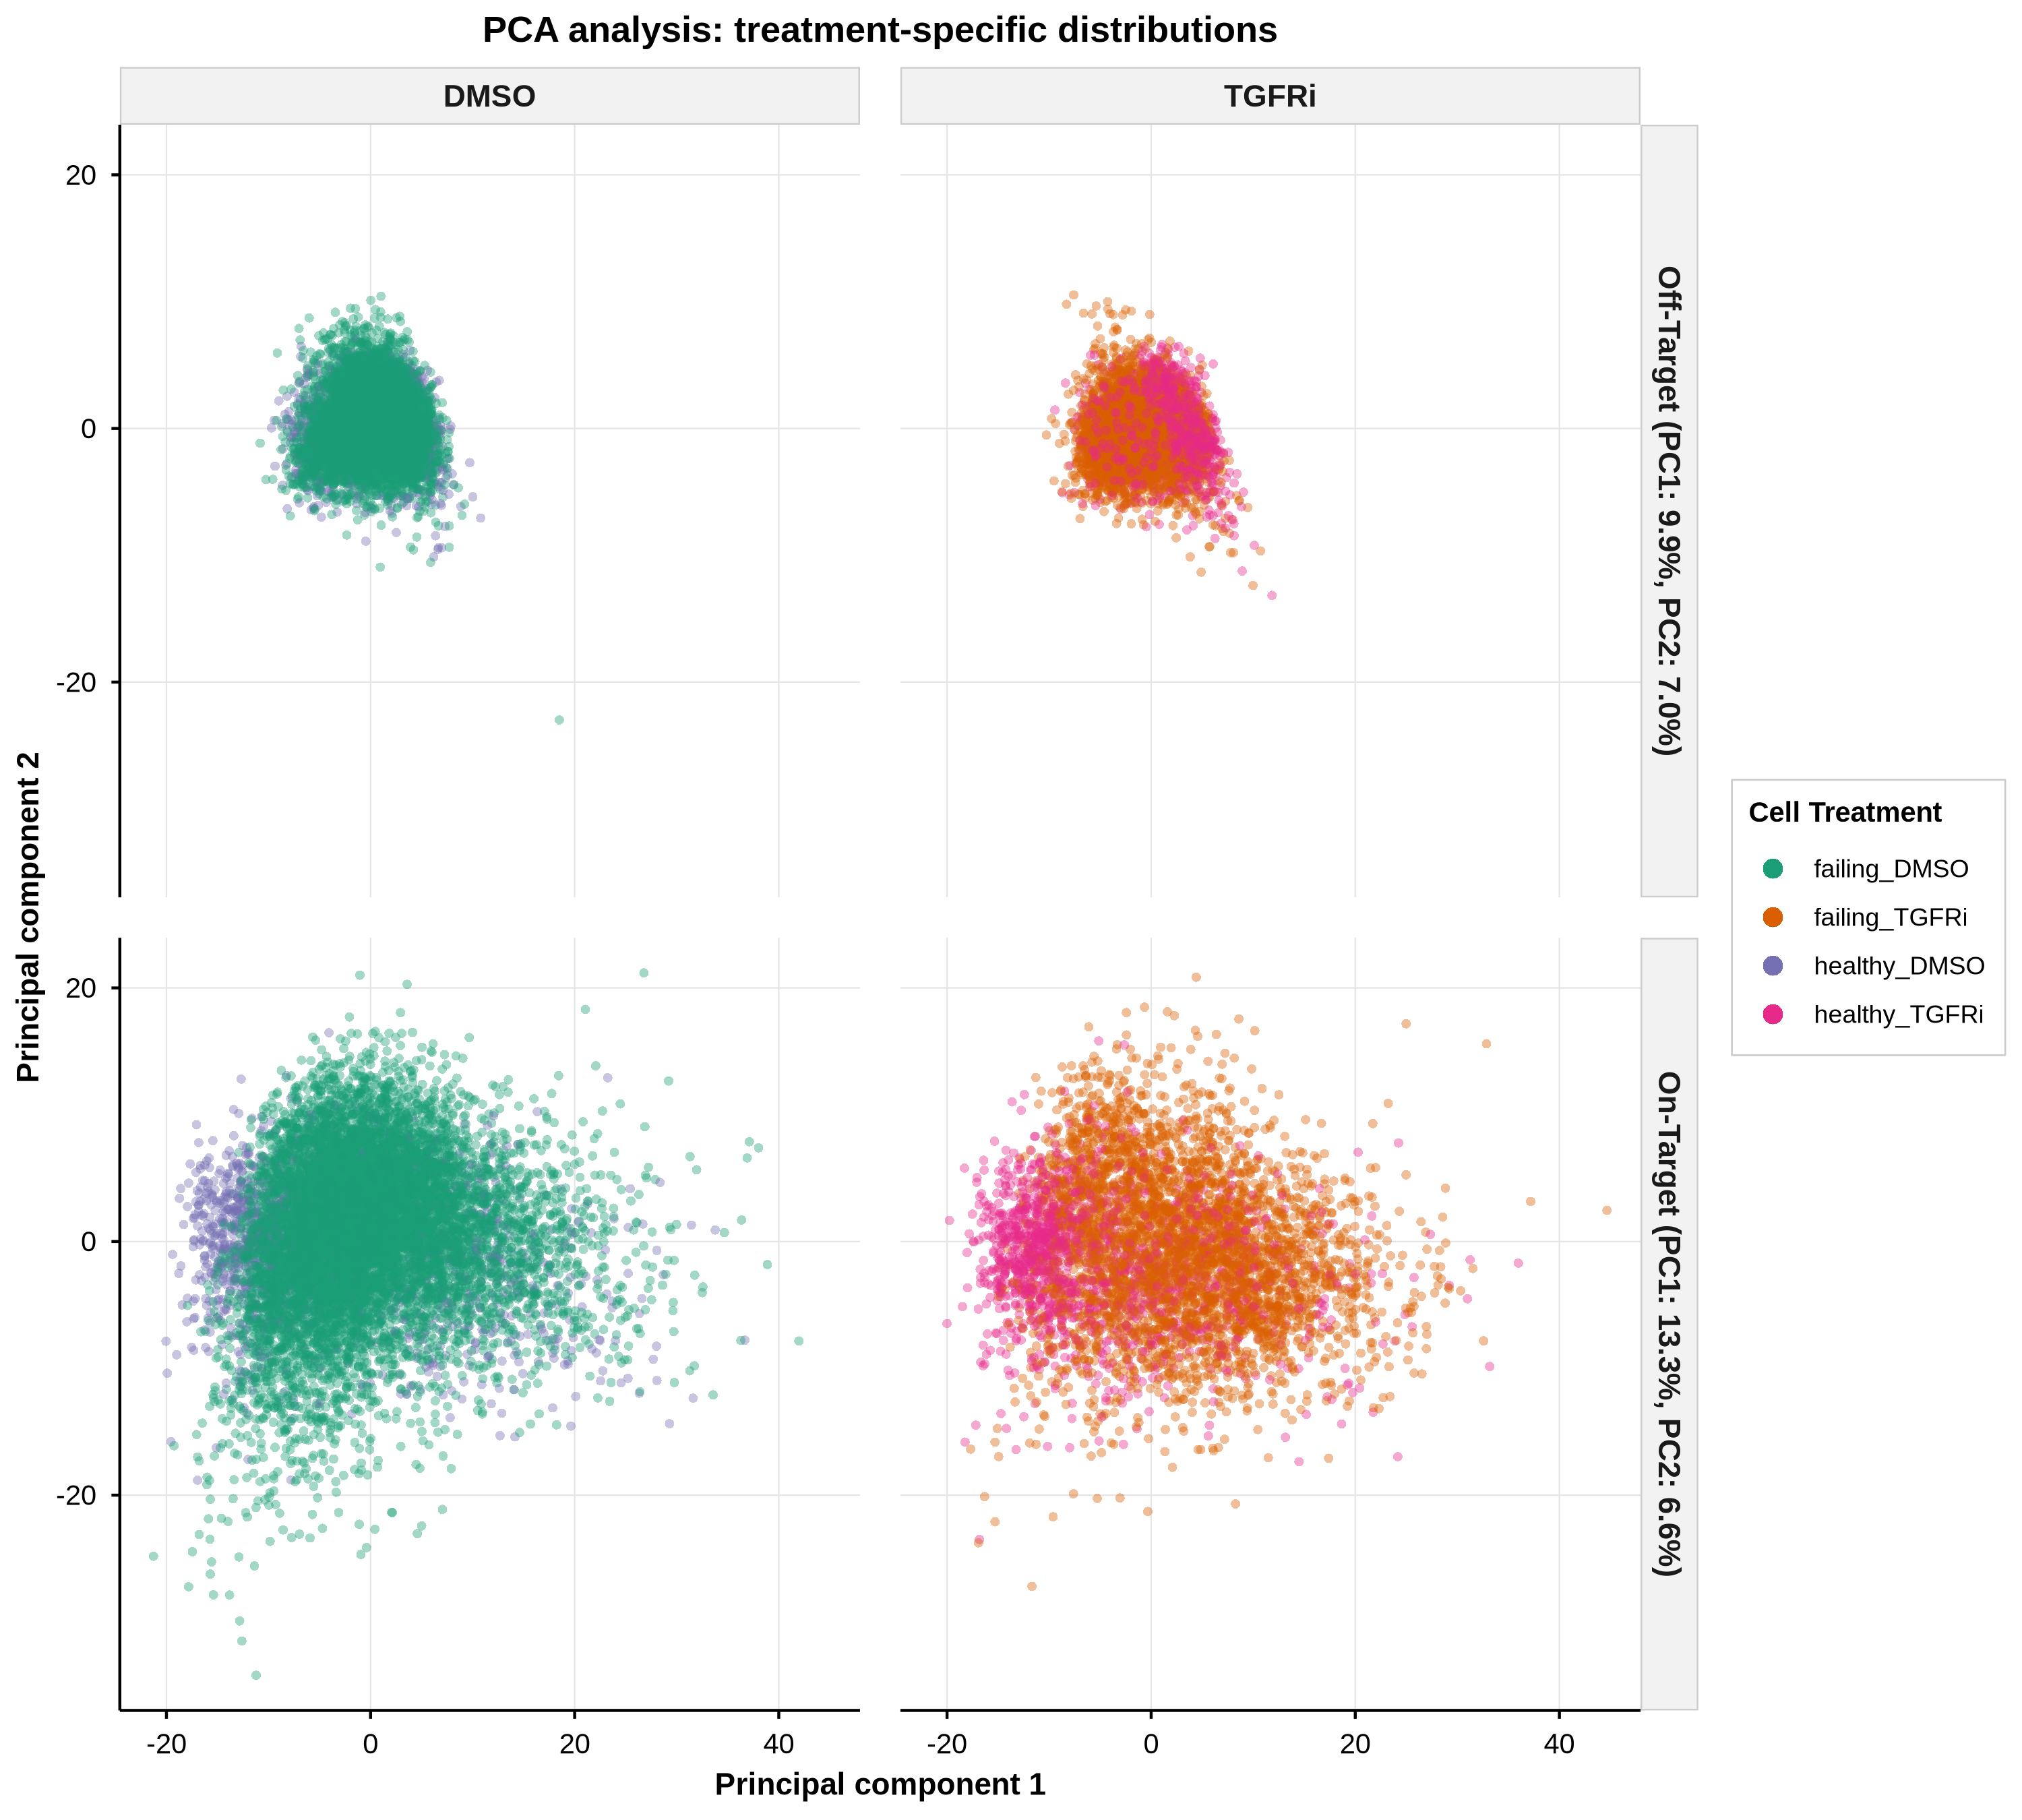

In [9]:
# Prepare data for faceting
pca_on_df_facet <- pca_on_df %>%
    mutate(signature_type = sprintf("On-Target (PC1: %.1f%%, PC2: %.1f%%)", pc1_var_on, pc2_var_on))

pca_off_df_facet <- pca_off_df %>%
    mutate(signature_type = sprintf("Off-Target (PC1: %.1f%%, PC2: %.1f%%)", pc1_var_off, pc2_var_off))

# Create faceted PCA plot
pca_faceted <- bind_rows(pca_on_df_facet, pca_off_df_facet) %>%
    mutate(
        Metadata_treatment = factor(Metadata_treatment, levels = c("DMSO", "TGFRi"))
    ) %>%
    ggplot(aes(x = PC1, y = PC2, color = Metadata_cell_treatment)) +
    geom_point(alpha = facet_point_alpha, size = facet_point_size, shape = point_shape) +
    scale_color_manual(values = color_palette, name = "Cell Treatment") +
    facet_grid(signature_type ~ Metadata_treatment) +
    labs(
        title = "PCA analysis: treatment-specific distributions",
        x = "Principal component 1",
        y = "Principal component 2"
    ) +
    guides(color = guide_legend(override.aes = list(alpha = legend_alpha, size = legend_size))) +
    theme(
        strip.text = element_text(face = "bold", size = 11),
        panel.spacing = unit(1, "lines")
    )

# Display plot
options(repr.plot.width = plot_width_faceted, repr.plot.height = plot_height_faceted, repr.plot.res = render_dpi)
print(pca_faceted)

In [10]:
# Save PCA faceted plot
ggsave(
    filename = file.path(figures_dir, "pca_facet_grid.png"),
    plot = pca_faceted,
    width = plot_width_faceted,
    height = plot_height_faceted,
    dpi = render_dpi,
    bg = "white"
)

cat("Saved PCA faceted plots to:", figures_dir, "\n")

Saved PCA faceted plots to: ./figures 


## Plotting UMAP embeddings

Load UMAP embeddings

In [11]:
# Load pre-computed UMAP results
umap_on_df <- read_parquet(umap_on_path)
umap_off_df <- read_parquet(umap_off_path)

# Create cell_treatment column
umap_on_df <- umap_on_df %>%
    mutate(Metadata_cell_treatment = paste(Metadata_cell_type, Metadata_treatment, sep = "_"))
umap_off_df <- umap_off_df %>%
    mutate(Metadata_cell_treatment = paste(Metadata_cell_type, Metadata_treatment, sep = "_"))

# Display structure
cat("UMAP ON shape:", nrow(umap_on_df), "×", ncol(umap_on_df), "\n")
cat("UMAP OFF shape:", nrow(umap_off_df), "×", ncol(umap_off_df), "\n")

# Display cell counts by treatment
cell_counts_umap <- umap_on_df %>%
    group_by(Metadata_treatment) %>%
    summarise(n_cells = n(), .groups = 'drop')

cat("\nCell counts by treatment:\n")
print(cell_counts_umap)

# Verify required columns exist
required_umap_cols <- c("UMAP1", "UMAP2", "Metadata_treatment")
if (!all(required_umap_cols %in% names(umap_on_df))) {
    stop("Required columns missing in UMAP data")
}

cat("\nUMAP data loaded successfully\n")

UMAP ON shape: 15793 × 23 
UMAP OFF shape: 15793 × 23 

Cell counts by treatment:
# A tibble: 2 × 2
  Metadata_treatment n_cells
  <chr>                <int>
1 DMSO                 10519
2 TGFRi                 5274

UMAP data loaded successfully


### UMAP visualization: overlay comparison

Side-by-side comparison of on-target and off-target UMAP projections.

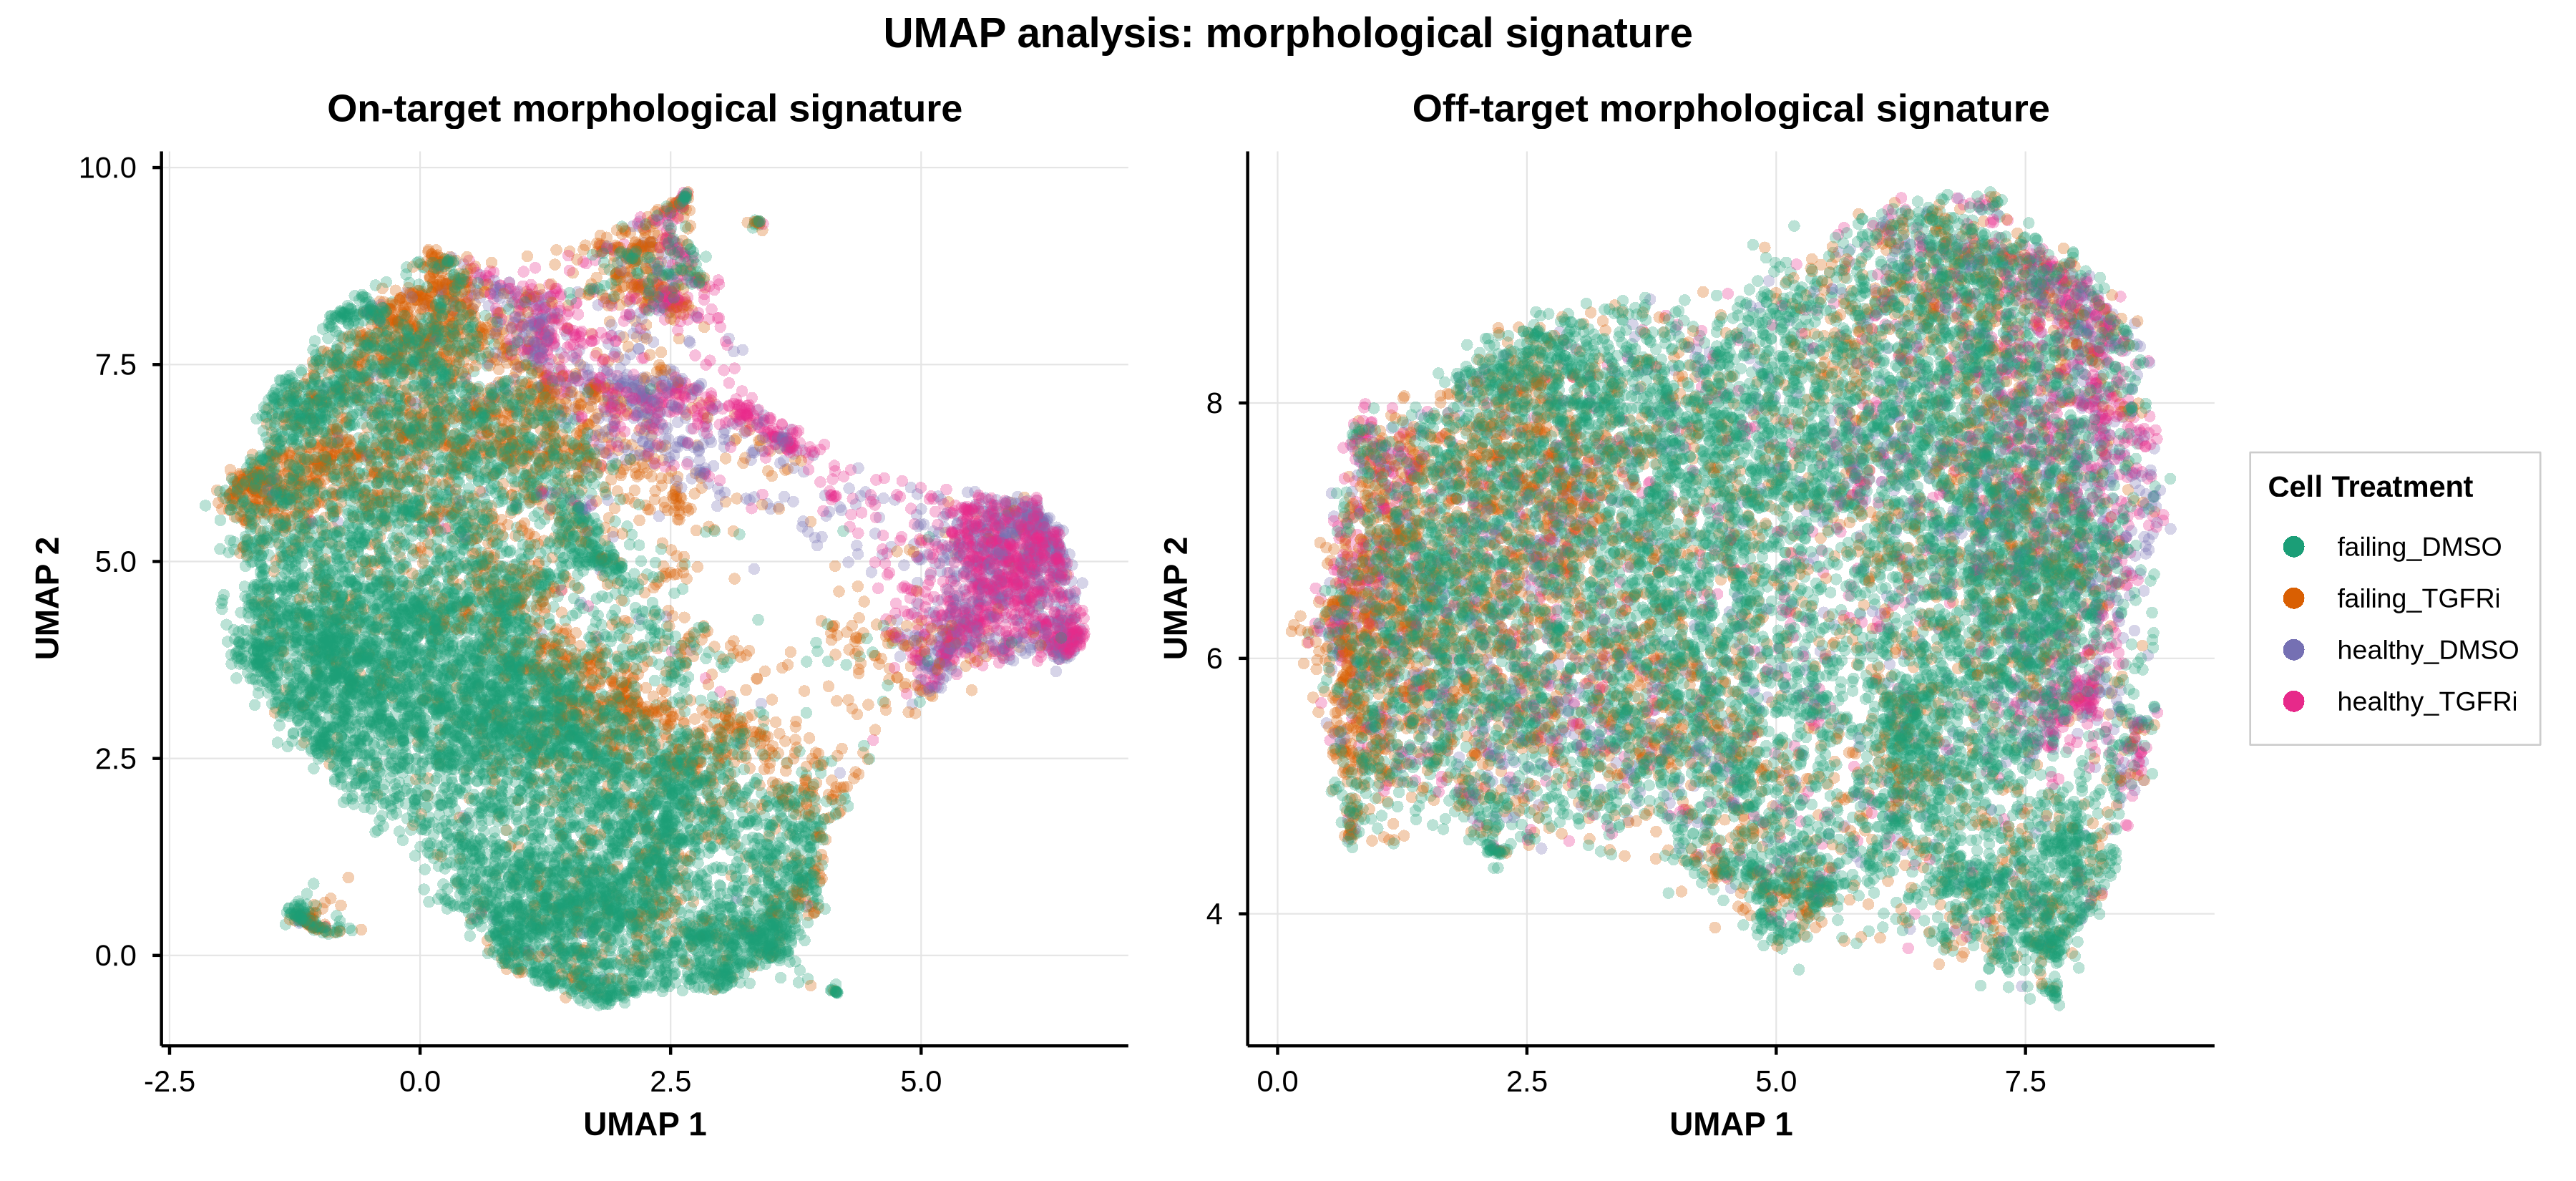

In [12]:
# Create on-target UMAP plot
plot_umap_on <- ggplot(umap_on_df, aes(x = UMAP1, y = UMAP2, color = Metadata_cell_treatment)) +
    geom_point(alpha = point_alpha, size = point_size, shape = point_shape) +
    scale_color_manual(values = color_palette, name = "Cell Treatment") +
    labs(
        title = "On-target morphological signature",
        x = "UMAP 1",
        y = "UMAP 2"
    ) +
    guides(color = guide_legend(override.aes = list(alpha = legend_alpha, size = legend_size)))

# Create off-target UMAP plot
plot_umap_off <- ggplot(umap_off_df, aes(x = UMAP1, y = UMAP2, color = Metadata_cell_treatment)) +
    geom_point(alpha = point_alpha, size = point_size, shape = point_shape) +
    scale_color_manual(values = color_palette, name = "Cell Treatment") +
    labs(
        title = "Off-target morphological signature",
        x = "UMAP 1",
        y = "UMAP 2"
    ) +
    guides(color = guide_legend(override.aes = list(alpha = legend_alpha, size = legend_size)))

# Combine plots using patchwork
umap_combined <- plot_umap_on + plot_umap_off +
    plot_layout(guides = "collect") +
    plot_annotation(
        title = "UMAP analysis: morphological signature",
        theme = theme(plot.title = element_text(face = "bold", size = 14, hjust = 0.5))
    )

# Display plot
options(repr.plot.width = plot_width_combined, repr.plot.height = plot_height_combined, repr.plot.res = render_dpi)
print(umap_combined)

In [13]:
# Save UMAP overlay comparison
ggsave(
    filename = file.path(figures_dir, "umap_on_off_comparison.png"),
    plot = umap_combined,
    width = plot_width_combined,
    height = plot_height_combined,
    dpi = render_dpi,
    bg = "white"
)
cat("Saved UMAP overlay plots to:", figures_dir, "\n")

Saved UMAP overlay plots to: ./figures 


### UMAP visualization: faceted by treatment

Individual treatment groups displayed separately to examine within-group distributions.

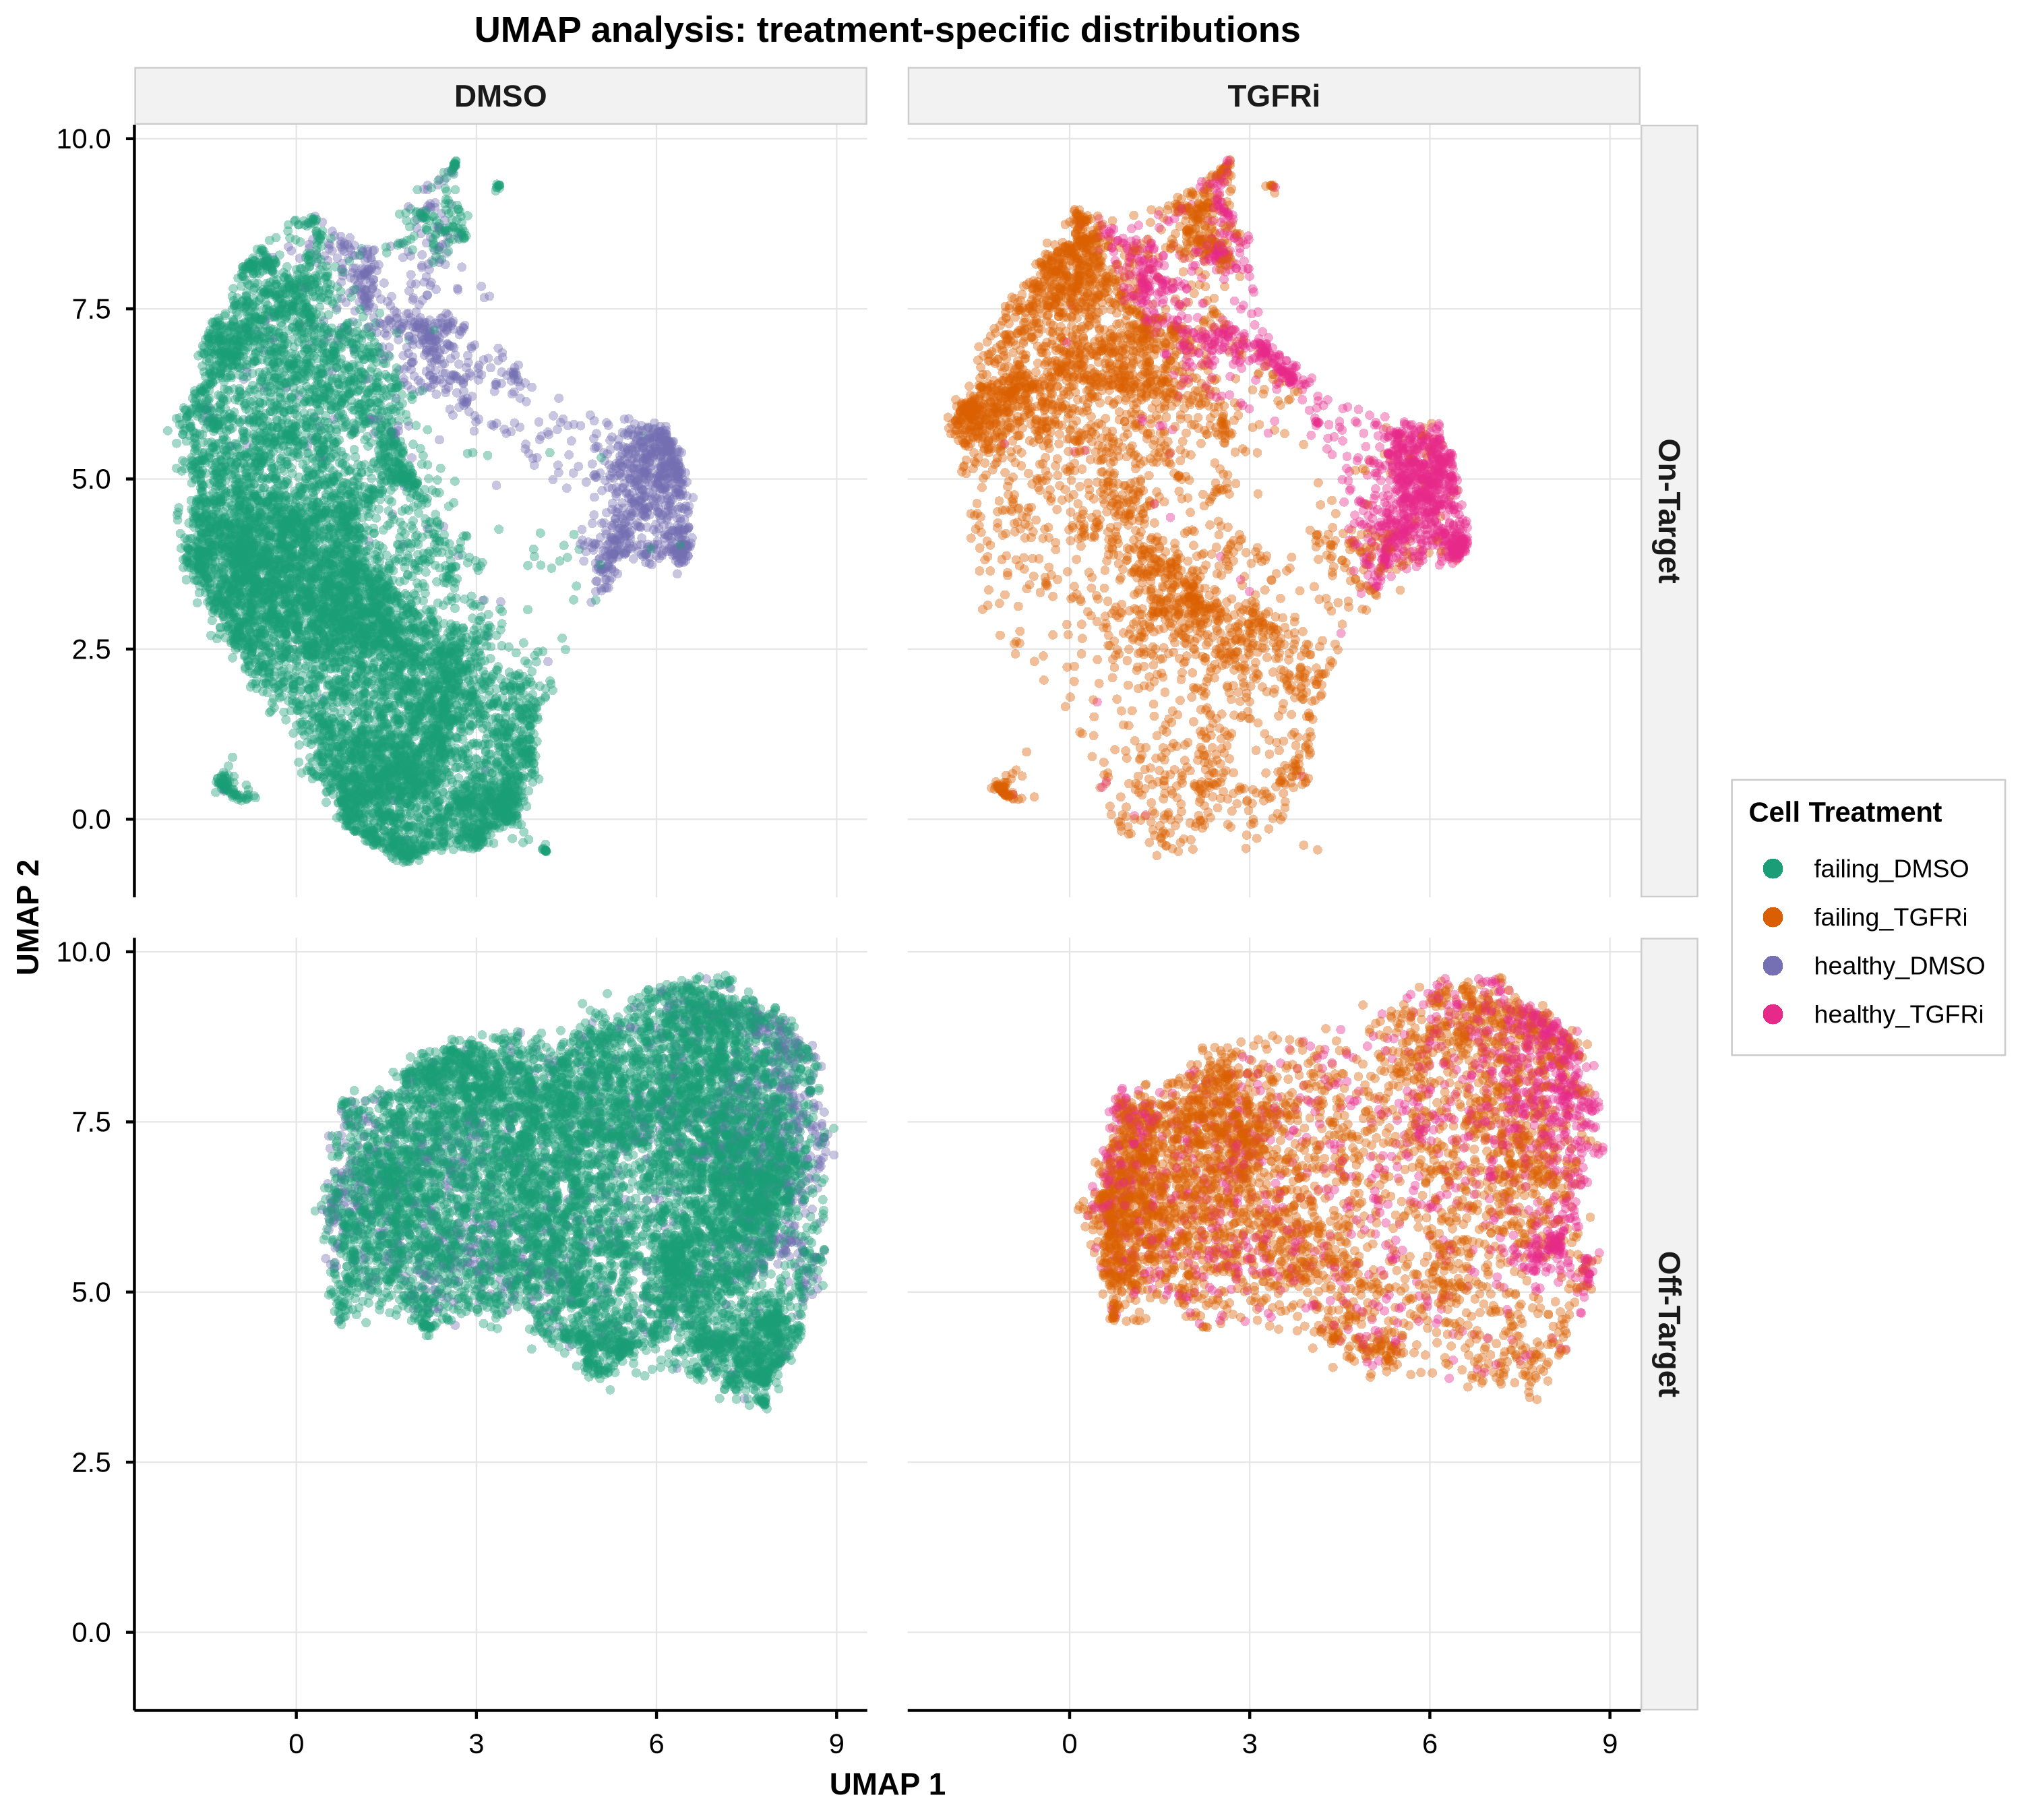

In [14]:
# Prepare data for faceting
umap_on_df_facet <- umap_on_df %>%
    mutate(signature_type = "On-Target")

umap_off_df_facet <- umap_off_df %>%
    mutate(signature_type = "Off-Target")

# Create faceted UMAP plot
umap_faceted <- bind_rows(umap_on_df_facet, umap_off_df_facet) %>%
    mutate(
        signature_type = factor(signature_type, levels = c("On-Target", "Off-Target")),
        Metadata_treatment = factor(Metadata_treatment, levels = c("DMSO", "TGFRi"))
    ) %>%
    ggplot(aes(x = UMAP1, y = UMAP2, color = Metadata_cell_treatment)) +
    geom_point(alpha = facet_point_alpha, size = facet_point_size, shape = point_shape) +
    scale_color_manual(values = color_palette, name = "Cell Treatment") +
    facet_grid(signature_type ~ Metadata_treatment) +
    labs(
        title = "UMAP analysis: treatment-specific distributions",
        x = "UMAP 1",
        y = "UMAP 2"
    ) +
    guides(color = guide_legend(override.aes = list(alpha = legend_alpha, size = legend_size))) +
    theme(
        strip.text = element_text(face = "bold", size = 11),
        panel.spacing = unit(1, "lines")
    )

# Display plot
options(repr.plot.width = plot_width_faceted, repr.plot.height = plot_height_faceted, repr.plot.res = render_dpi)
print(umap_faceted)

In [15]:
# Save UMAP faceted plot
ggsave(
    filename = file.path(figures_dir, "umap_facet_grid.png"),
    plot = umap_faceted,
    width = plot_width_faceted,
    height = plot_height_faceted,
    dpi = render_dpi,
    bg = "white"
)

cat("Saved UMAP faceted plots to:", figures_dir, "\n")

Saved UMAP faceted plots to: ./figures 


### UMAP visualization: KDE contour plots

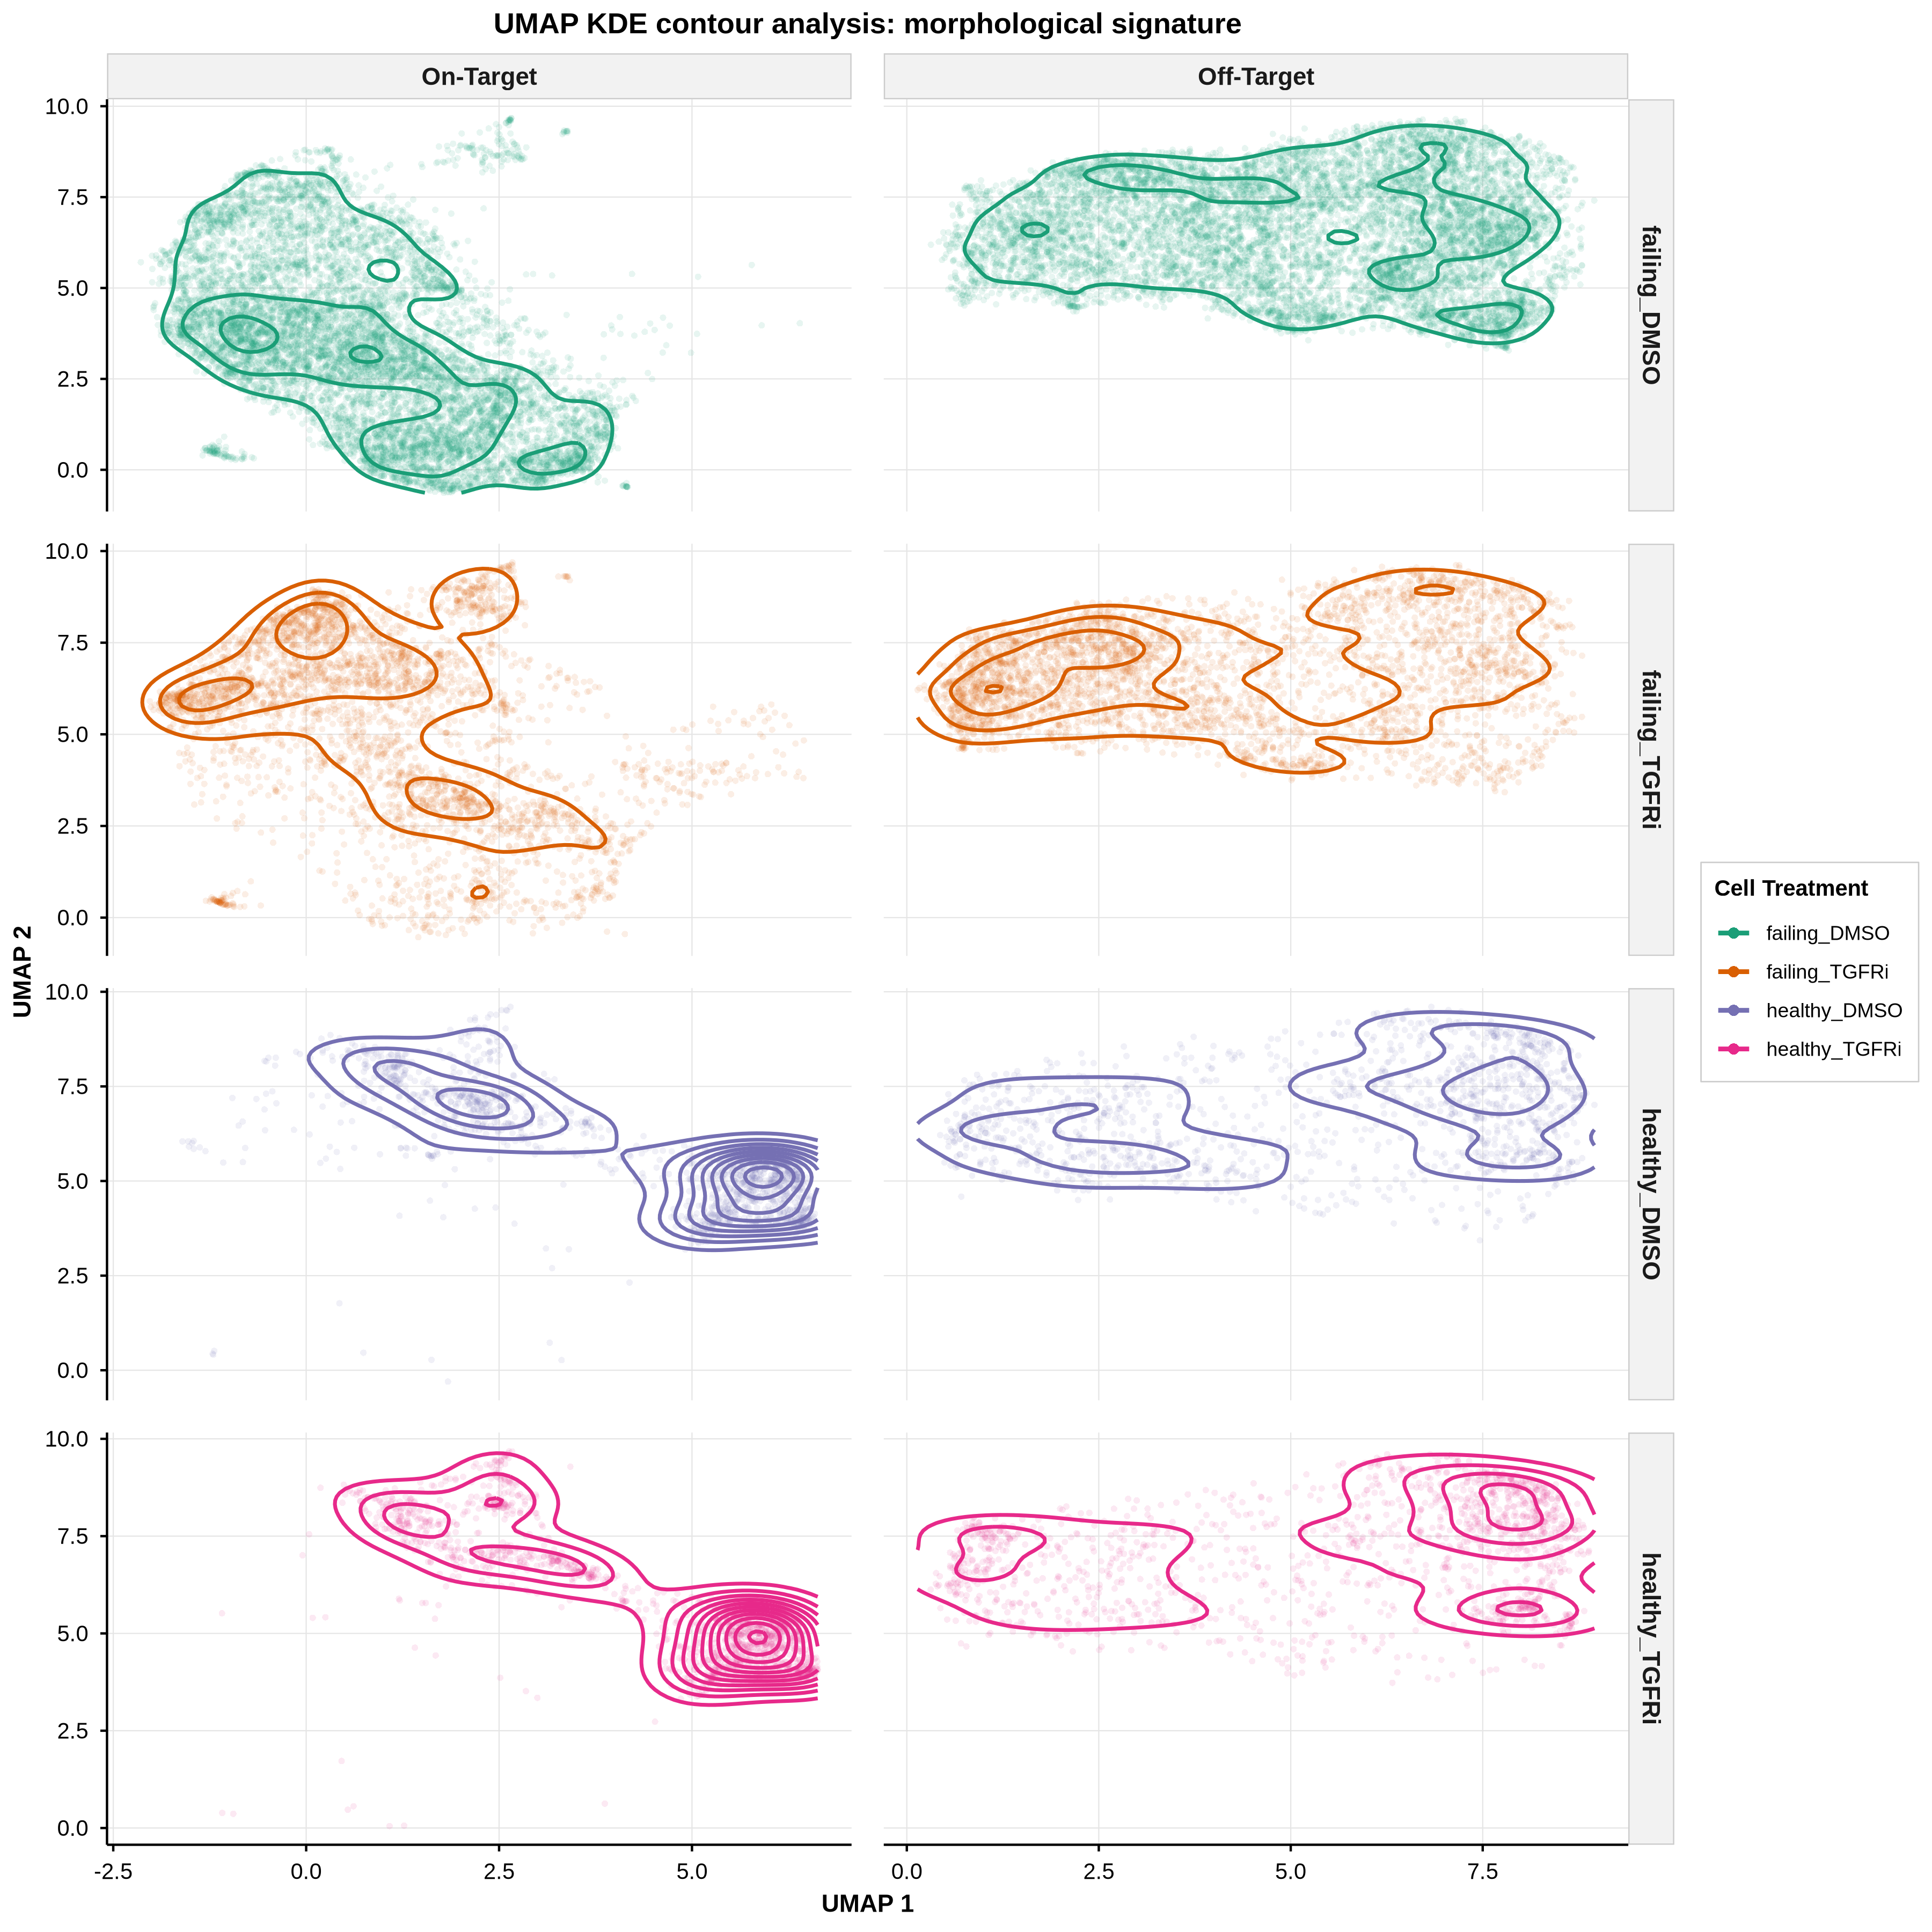

In [16]:
# Prepare combined data with signature type for faceting
umap_on_contour_df <- umap_on_df %>% mutate(signature_type = "On-Target")
umap_off_contour_df <- umap_off_df %>% mutate(signature_type = "Off-Target")

umap_contour_df <- bind_rows(umap_on_contour_df, umap_off_contour_df) %>%
    mutate(
        signature_type = factor(signature_type, levels = c("On-Target", "Off-Target"))
    )

# Faceted contour plot: signature_type (columns) x cell_treatment (rows)
umap_contour_combined <- ggplot(umap_contour_df, aes(x = UMAP1, y = UMAP2, color = Metadata_cell_treatment)) +
    geom_point(alpha = 0.1, size = 1, shape = point_shape) +
    geom_density_2d(linewidth = 0.8, bins = 12) +
    scale_color_manual(values = color_palette, name = "Cell Treatment") +
    facet_grid(Metadata_cell_treatment ~ signature_type, scales = "free") +
    labs(
        title = "UMAP KDE contour analysis: morphological signature",
        x = "UMAP 1",
        y = "UMAP 2"
    ) +
    guides(color = guide_legend(override.aes = list(alpha = 1, size = 2, linewidth = 1))) +
    theme(
        strip.text = element_text(face = "bold", size = 11),
        panel.spacing = unit(1, "lines")
    )

# Display plot
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = render_dpi)

# Save UMAP KDE contour plot
ggsave(
    filename = file.path(figures_dir, "umap_kde_contour_faceted.png"),
    plot = umap_contour_combined,
    width = plot_width_faceted,
    height = plot_height_faceted,
    dpi = render_dpi,
    bg = "white"
)
umap_contour_combined

Make a gif out of the UMAP on and off plots. 

In [17]:
# Define the order of treatments
treatment_order <- c("failing_DMSO", "failing_TGFRi", "healthy_DMSO", "healthy_TGFRi")

# Extract axis limits from the static plot
xlim_vals <- ggplot_build(umap_contour_combined)$layout$panel_params[[1]]$x.range
ylim_vals <- ggplot_build(umap_contour_combined)$layout$panel_params[[1]]$y.range

plot_list <- list()

for (treat in treatment_order) {
  df_sub <- umap_contour_df %>% filter(Metadata_cell_treatment == treat)
  p <- ggplot(df_sub, aes(x = UMAP1, y = UMAP2, color = signature_type)) +
    geom_point(alpha = 0.1, size = 1, shape = point_shape) +
    geom_density_2d(linewidth = 0.8, bins = 12) +
    scale_color_manual(values = c("On-Target" = "#1b9e77", "Off-Target" = "#d95f02")) +
    facet_grid(. ~ signature_type) +
    labs(
      title = paste("UMAP KDE contour:", treat),
      x = "UMAP 1",
      y = "UMAP 2"
    ) +
    xlim(xlim_vals) +
    ylim(ylim_vals) +
    theme(
      strip.text = element_text(face = "bold", size = 11),
      panel.spacing = unit(1, "lines")
    )
  fname <- paste0("tmp_", treat, ".png")
  ggsave(fname, plot = p, width = 12, height = 6, dpi = 300, bg = "white")
  plot_list[[treat]] <- image_read(fname)
}

gif <- image_animate(image_join(plot_list), fps = 1)
image_write(gif, path = file.path(figures_dir, "umap_kde_contour_by_treatment.gif"))
file.remove(paste0("tmp_", treatment_order, ".png"))

Warning message:
“Removed 2137 rows containing non-finite outside the scale range
(`stat_density2d()`).”
Warning message:
“Removed 2137 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 625 rows containing non-finite outside the scale range
(`stat_density2d()`).”
Warning message:
“Removed 625 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 549 rows containing non-finite outside the scale range
(`stat_density2d()`).”
Warning message:
“Removed 549 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 646 rows containing non-finite outside the scale range
(`stat_density2d()`).”
Warning message:
“Removed 646 rows containing missing values or values outside the scale range
(`geom_point()`).”


[1] TRUE TRUE TRUE TRUE